# Aprendizaje por refuerzo profundo - Libreta 7
*por Roberto-Esteban López*

Objetivos:
- Presentar métodos de discretización para utilizar funciones tabulares
- Programar con pytorch una red y un bucle de entrenamiento basado en MC

In [1]:
!pip install gif
!git clone https://github.com/Bobobert/RL_Toy
!pip install /content/RL_Toy/

fatal: destination path 'RL_Toy' already exists and is not an empty directory.
Processing ./RL_Toy
  Created wheel for RL-Toy: filename=RL_Toy-0b7-cp37-none-any.whl size=16561 sha256=d518044c78b192f723270bbb425b0854cb2b6bb964a1bbc8feb8ed1679e678c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-uqxcd5wl/wheels/5a/37/15/8aacf8230322d696d3fa708cb9d23ceb83e072d683a452e343
Successfully built RL-Toy
  Found existing installation: RL-Toy 0b7
    Uninstalling RL-Toy-0b7:
      Successfully uninstalled RL-Toy-0b7


In [2]:
# Colab virtualDisplay for gym Environments
# This may not be necesary outside google colab
!sudo apt update
!apt install python-opengl
!apt install ffmpeg
!sudo apt-get install xvfb
!pip3 install pyvirtualdisplay

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/graphics-driv

**Para Colab es necesario reiniciar el entorno después de ejecutar la celda de arriba**

In [3]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1280, 720))
virtual_display.start()

In [4]:
# Importar librerias
## Algebra y  graficas
import matplotlib.pyplot as plt
import numpy as np

## GYM 
from gym import make

## Pytorch
import torch
from torch import nn
from torch import optim

## RL_Toy
from RL_Toy.utils import render, runAgent, runEnv, Q_function
from RL_Toy.base import Policy, Agent

## Aproximaciones sobre el espacio de valores

En esta libreta se hace el enfoque en usar las técnicas ya vistas para la predicción de la función de valor ahora con aproximadores para estas aproximaciones (sí, una sobre otra). Hasta el momento, nuestros métodos son de las formas on-line, off-line, on-policy, off-policy  con métodos Monte Carlo y Diferencias temporales (TD). Estas nos guían la dirección en la que los valores de la predicción de $V \approx v_\pi$.

En esta ocasion se utilizarán solamente los entornos de gym, y para aproximadores parametricos la librería de pytorch. Se puede cambiar el entorno de ejecución de esta libreta a GPU para acelerar algunas tareas de redes neuronales, pero esto es recomendable solamente para muchos datos y redes complejas.

Creamos un nuevo entorno de gym, los siguientes ejericicios estan pensandos en los incluidos en la categoria "classic control".

In [5]:
env = make("CartPole-v0")

Mean accumulate Reward 23.00, episodes 4


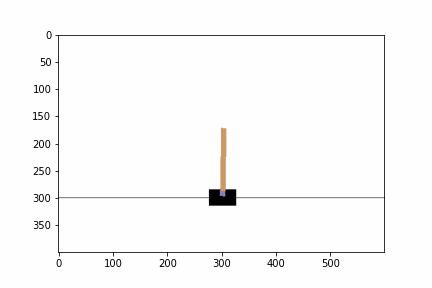

In [6]:
runEnv(env, 100)

In [6]:
# Funciones de prueba y graficas
def test(agent:Agent, n:int = 30):
    results , _ = agent.test(n_test = n)
    print("Return: Mean {}, Std {}".format(np.mean(results), np.std(results)))
    return results

def graphResults(means, stds, testFreq, mod:str, dpi=200):
    mean = np.array(means)
    stds = np.array(stds)
    fig = plt.figure(dpi=dpi)
    plt.title("{}: Mean Return per Episode".format(mod))
    plt.xlabel("Episode")
    plt.ylabel("Mean acumulate Reward")
    x = np.arange(0,len(means)*testFreq, testFreq)
    plt.plot(x, means, label = "Accumulate Reward", lw = 2)
    plt.fill_between(x, means - stds, means + stds, alpha = 0.1)

### Analizando un entorno con espacio continuo

Los siguientes comandos son de la interfaz de gym, con los cuales todos los entornos nos devolveran los objetos que representan en este caso el espacio de observaciones y el de aciones.

In [7]:
env.observation_space

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

In [10]:
env.observation_space.sample()

array([-3.5609419e+00,  8.0142727e+37,  2.2092287e-01, -1.3895998e+38],
      dtype=float32)

In [12]:
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

In [13]:
env.observation_space.high

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

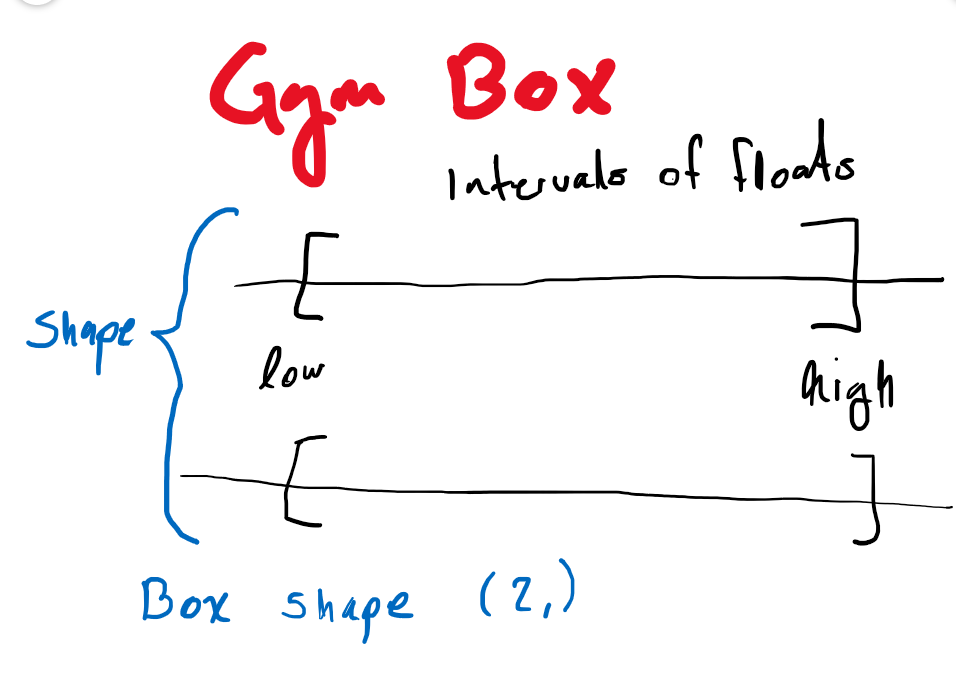

### Convertir un espacio de medida continuo a discreto

A continuacion, se presenta una de las maneras sencilla de hacer esta tarea como ejemplo. No es la unica o particularmente la mejor manera. Usualmente estas tareas tienen que ser especializadas al tipo de problema que se este manejando. 

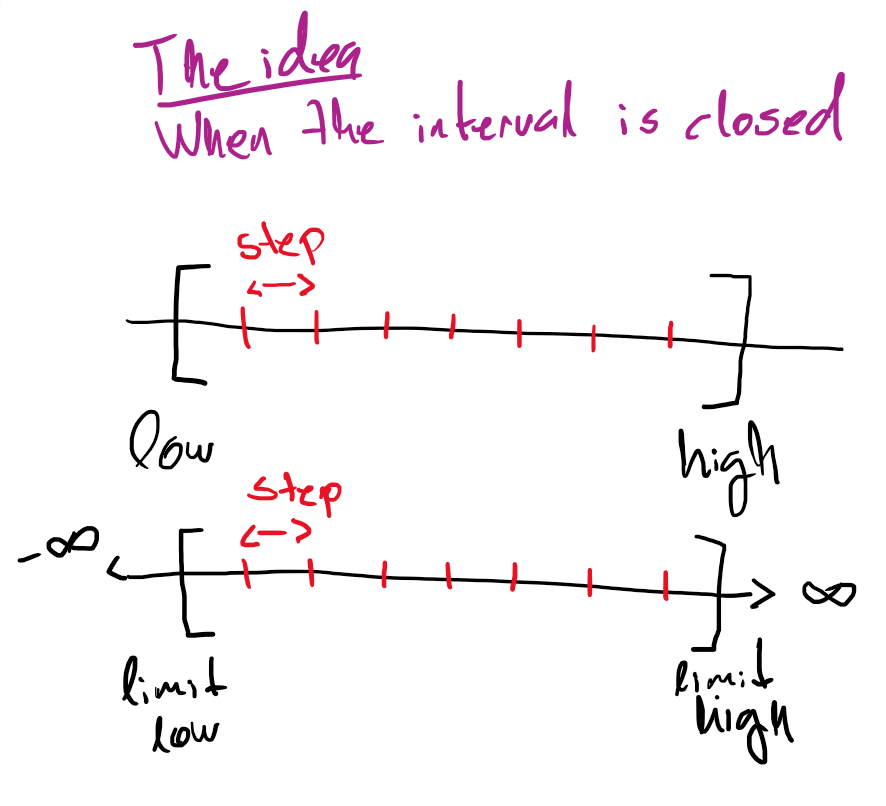

El caso a continuacion esta diseñada para los entornos de "classic control" en mente.

In [14]:
from math import ceil, floor

def toDiscreteSpace(box_space, step: list, limits = None):
    """
    Function to generate a discrete space from a continuos one

    parameters
    ----------
    box_space: gym.spaces.Box
        Expecting a box type of space to generate a discrete one
    step: list
        A list with the step sizes for each dimension. This should match
        the observation_space.shape
    limits: list
        A list with the limits per interval, if None no limits are applied.
        Default is None
    """
    low = box_space.low
    high = box_space.high
    shape = box_space.shape
    spaces = []
    if limits is None:
        limits = [None for i in step]
    for l, h, step_, limit in zip(low, high, step, limits):
        # Calculating how many boxes are needed
        if limit is not None:
            l, h = limit
        boxes = ceil(abs(h - l)/step_)
        spaces += [np.linspace(l, h, num = boxes)]

    return spaces

def cartesian_product(*arrays):
    """
    Cartesian product of ndarrays
    Extracted from https://stackoverflow.com/a/11146645
    """
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [15]:
# Función a usar delante
def checkForTuple(obj):
    if isinstance(obj, np.ndarray):
        return tuple(obj.tolist())
    elif isinstance(obj, (list, tuple)):
        return tuple(obj)
    else:
        raise TypeError("Object type {} not supported".format(type(obj)))

In [18]:
# Clase del repositorio
class gymPolicyDiscreteFromCon(Policy):
    """
    Gym policy from a continuos observation space and a
    discrete action space

    parameters
    ----------
    env: gym.Environment
        A gym environment type object
    step: list
        A list with the step sizes for each dimension. This should match
        the observation_space.shape
    limits: list
        A list with the limits per interval, if None no limits are applied.
        Default is None
    epsilon: float

    """
    def __init__(self, env, steps:list = [], limits = None, epsilon:float = 0.0):

        self.spaces = toDiscreteSpace(env.observation_space, steps, limits)
        self.observation_space = cartesian_product(*self.spaces)
        self.aS = env.action_space
        self.pi = dict()

        # using the product to make a dictionary
        for i in self.observation_space:
            i = tuple(i.tolist())
            self.pi[i] = self.aS.sample()
        # deleting the product

        self.steps, self.boxes = steps, []
        self.low = env.observation_space.low
        self.high = env.observation_space.high
        if limits is None:
            limits = [None for i in steps]
        else:
            for i, l in enumerate(limits):
                if l is not None:
                    self.low[i] = l[0]
                    self.high[i] = l[1]
        for l, h, step_, limit in zip(self.low, self.high, steps, limits):
        # Calculating how many boxes are needed
            if limit is not None:
                l,h = limit
            self.boxes += [ceil(abs(h - l)/step_)]
        self.epsilon = epsilon
        self.test = False

    def getAction(self, state):
        if (np.random.uniform() > self.epsilon) or self.test:
            return self.pi[state]
        return self.aS.sample()

    def update(self, state, action):
        assert self.aS.contains(action),\
            "Action must be contained in the environtment's action space"
        self.pi[state] = action 

    def getState(self, state):
        """
        Process a continuos input state into the discrete one. Returns a hashable 
        tuple.
        """
        state = checkForTuple(state)
        assert len(state) == len(self.boxes),\
            "State input must have the same shape as observation_space"
        pos = []
        for s, l, step, b, space in zip(state, self.low, self.steps, self.boxes, self.spaces):
            i = floor((s - l) / step)
            # Bound 
            if i < 0:
                i = 0
            elif i >= b:
                i = b - 1
            pos += [space[i]]
        return tuple(pos)
            

In [19]:
class gymAgentCon2Dis(Agent):
    def __init__(self, env, env_test = None, **kwargs):
        self.env = env
        self.env_test = env_test

        self.policy = gymPolicyDiscreteFromCon(env, **kwargs)

        super().__init__()

    def processObs(self, obs):
        return self.policy.getState(obs)

In [20]:
agent = gymAgentCon2Dis(env,  steps = [0.25, 0.25, 0.025, 0.25],
                              limits = [None, (-5,5), None, (-5,5)],
                              epsilon = 0.5)
test(agent)

Return: Mean 40.6, Std 24.88453334905037


[96.0,
 41.0,
 26.0,
 66.0,
 15.0,
 17.0,
 24.0,
 9.0,
 35.0,
 36.0,
 25.0,
 53.0,
 67.0,
 21.0,
 28.0,
 29.0,
 41.0,
 47.0,
 72.0,
 51.0,
 37.0,
 36.0,
 17.0,
 25.0,
 11.0,
 11.0,
 104.0,
 69.0,
 81.0,
 28.0]

In [21]:
agent.policy.observation_space.shape

(2121600, 4)

In [17]:
agent.policy.spaces

[array([-4.80000019, -4.5473686 , -4.29473701, -4.04210542, -3.78947383,
        -3.53684225, -3.28421066, -3.03157907, -2.77894748, -2.52631589,
        -2.2736843 , -2.02105271, -1.76842112, -1.51578953, -1.26315794,
        -1.01052636, -0.75789477, -0.50526318, -0.25263159,  0.        ,
         0.25263159,  0.50526318,  0.75789477,  1.01052636,  1.26315794,
         1.51578953,  1.76842112,  2.02105271,  2.2736843 ,  2.52631589,
         2.77894748,  3.03157907,  3.28421066,  3.53684225,  3.78947383,
         4.04210542,  4.29473701,  4.5473686 ,  4.80000019]),
 array([-5.        , -4.74358974, -4.48717949, -4.23076923, -3.97435897,
        -3.71794872, -3.46153846, -3.20512821, -2.94871795, -2.69230769,
        -2.43589744, -2.17948718, -1.92307692, -1.66666667, -1.41025641,
        -1.15384615, -0.8974359 , -0.64102564, -0.38461538, -0.12820513,
         0.12820513,  0.38461538,  0.64102564,  0.8974359 ,  1.15384615,
         1.41025641,  1.66666667,  1.92307692,  2.17948718,  2

In [27]:
agent.processObs((-4.810, -2, -0.36, -1037986398125454))

(-4.800000190734863, -1.9230769230769234, -0.36810581611864496, -5.0)

### Metodo Monte-Carlo Discreto para entornos de gym


In [28]:
def GLIE_MC(agent:Agent, iters: int, episodes:int = 30,
            gamma:float = 0.99, freqTest: int = 10**2, epsLife: int = None):
    """
    GLIE MC given an epsilon greedy policy

    parameters
    -----------
    agent: The Agent object which contains the environment
        and the policy
    iters: integer > 0
        Total number of iterations to run the policy and to improve from
    episodes: integer > 0
        Number of episodes to sample from to evaluate the policy
    gamma: float
        Discount factor
    freqTest: integer > 0
        The frequency in which a test to evaluate the policy performance is done
    """

    assert (gamma >= 0) and (gamma <= 1), \
        "Gamma discount factor must be in the interval [0,1]"
    assert episodes > 0, \
        "episodes needs to be am integer greater or equal to 1 iteration."
    assert iters > 0, \
        "iters needs to be am integer greater or equal to 1 iteration."

    if epsLife is None:
        epsLife = iters
    
    env = agent.env
    policy = agent.policy
    prosObs = agent.processObs
    
    testMean, testStd = [], []
    for iter in range(iters):

        Q = Q_function()
        N = Q_function()
        # Adjust policy's episilon
        policy.epsilon = max(0, 1 - ((iter + 1) / epsLife))

        # Do evaluation if it is time
        if iter % freqTest == 0:
            returns, _ = agent.test(n_test = 30)
            testMean += [np.mean(returns)]
            testStd += [np.std(returns)]

        for episode in range(episodes):
            # Sample a whole episode
            obs = env.reset()
            done, states, actions, rewards, returns = False, [], [], [], []
            while not done:
                state = prosObs(obs)
                action = policy.getAction(state)
                # Save the states and action seen
                states += [state]
                actions += [action]
                # Add 1 to the counter for the pair
                N[(state, action)] = N[(state, action)] + 1
                # Do the step on the environment
                obs, reward, done, info = env.step(action) #Modificacion ligera
                rewards += [reward]
                returns += [0.0]

            # After done, calculate the returns
            returns[-1] = rewards[-1]
            for i in range(len(rewards) - 2, -1, -1): # i goes from the top to bottom of the lists
                returns[i] = rewards[i] + gamma * returns[i + 1]

            # Update the value function
            for i in range(len(states)):
                state_action = (states[i], actions[i])
                actualQ = Q[state_action]
                actualN =  1 / N[state_action]
                Q[state_action] = actualQ + actualN * (returns[i] - actualQ)

        # Update the policy in a greedy manner
        for state in Q.getStates():
            maxAction = Q.maxAction(state)
            agent.update(state, maxAction)

    graphResults(testMean, testStd, freqTest * episodes, "GLIE")
    return Q, N

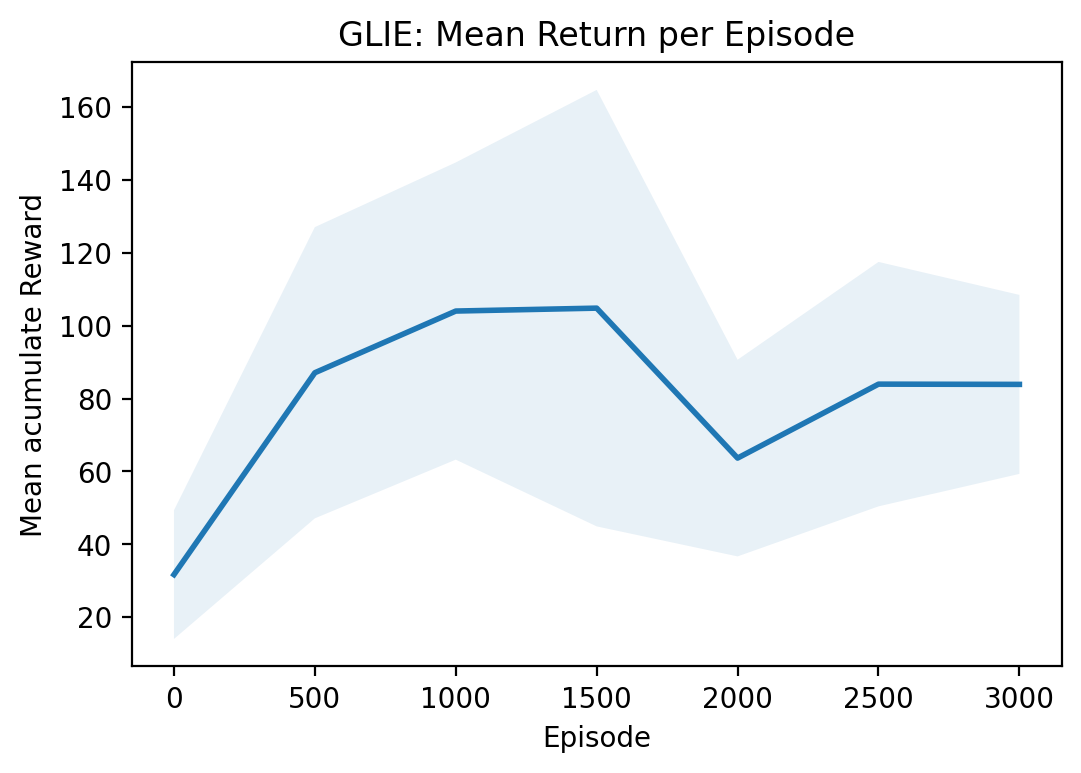

In [29]:
Q, N = GLIE_MC(agent, 31, episodes=100, freqTest=5, epsLife=50)

In [30]:
_ = test(agent)

Return: Mean 67.03333333333333, Std 23.075937443338873


Mean accumulate Reward 0.00, episodes 1


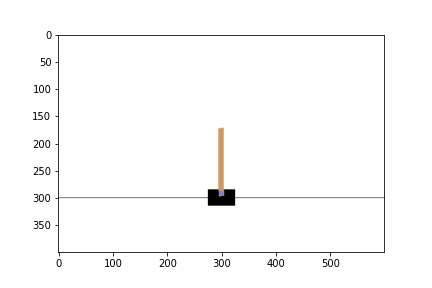

In [31]:
runAgent(agent, 100)

### Q-Learning Discreto para entornos de gym


In [32]:
def Q_learning(agent:Agent, episodes:int,
          gamma:float = 0.99, alpha: float = 0.01, freqTest: int = 10**2,
          epsLife:int = None):
    """
    Q_learning algorithm

    parameters
    -----------
    agent: The Agent object which contains the environment
        and the policy
    epsidodes: integer > 0
        Total number of episodes to run the policy and to improve from
    gamma: float
        Discount factor
    alpha: float > 0
        Learning step
    freqTest: integer > 0
        The frequency in which a test to evaluate the policy performance is done
    """
    assert (alpha > 0), "alpha learn step must be in the interval [0,1]"
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert episodes > 0, "episodes needs to be am integer greater or equal to 1 iteration."

    Q = Q_function()
    prosObs = agent.processObs
    policy = agent.policy
    if epsLife is None:
        epsLife = episodes

    testMean, testStd = [], []
    for episode in range(episodes):

        # Do evaluation if it is time
        if episode % freqTest == 0:
            returns, _ = agent.test(n_test = 30)
            testMean += [np.mean(returns)]
            testStd += [np.std(returns)]

        # Change epsilon
        policy.epsilon = max(0, (1 - (episode) / epsLife))

        # Sample a whole episode
        obs = env.reset()
        state = prosObs(obs)
        done = False
        while not done:
            action = policy.getAction(state)
            obs, reward, done, info = env.step(action)
            state2 = prosObs(obs)
            action2_max = Q.maxAction(state2)
            actualQ = Q[(state, action)]
            td_target = reward + gamma * Q[(state2, action2_max)]
            Q[(state,action)] = actualQ + alpha * (td_target - actualQ)
            agent.update(state, Q.maxAction(state))
            state = state2

    graphResults(testMean, testStd, freqTest, "Q-Learning")
    return Q

In [34]:
agentQ = gymAgentCon2Dis(env,  steps = [0.25, 0.25, 0.025, 0.25],
                              limits = [None, (-5,5), None, (-5,5)],
                              epsilon = 0.7)
test(agentQ)

Return: Mean 18.566666666666666, Std 14.268107403888187


[27.0,
 11.0,
 28.0,
 21.0,
 13.0,
 10.0,
 14.0,
 12.0,
 13.0,
 33.0,
 18.0,
 87.0,
 16.0,
 15.0,
 13.0,
 12.0,
 13.0,
 9.0,
 31.0,
 11.0,
 11.0,
 12.0,
 11.0,
 17.0,
 23.0,
 13.0,
 12.0,
 11.0,
 25.0,
 15.0]

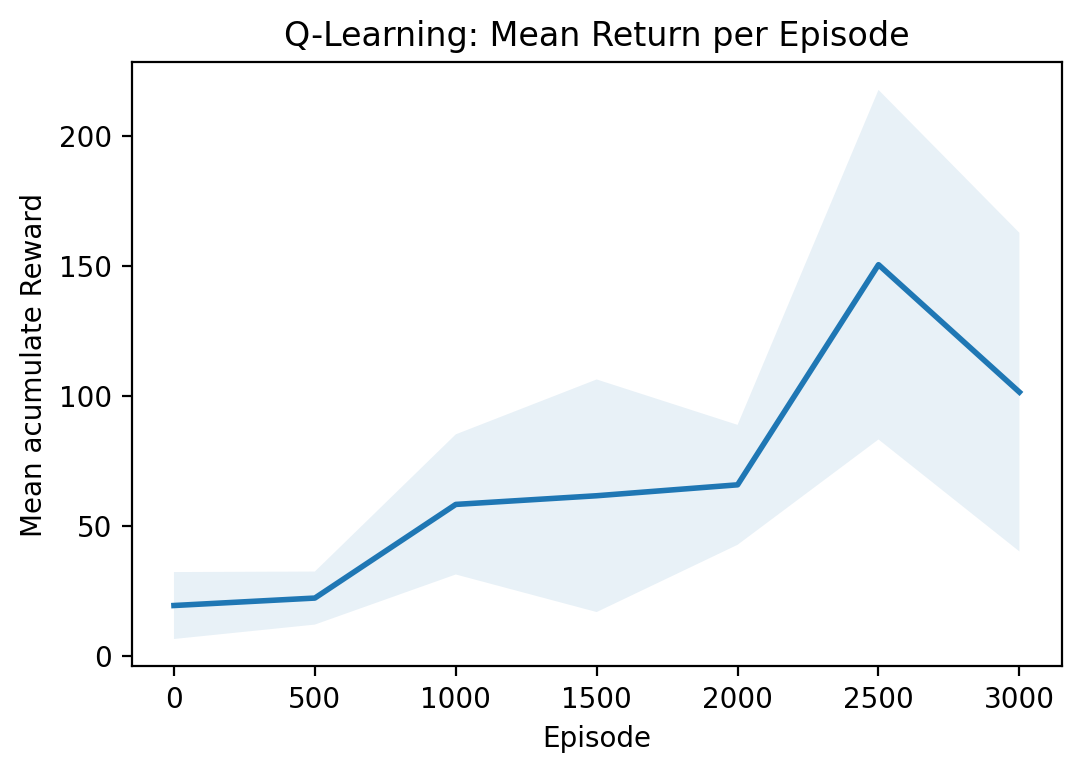

In [35]:
Q_q = Q_learning(agentQ, episodes = 3*10**3 + 1, 
                 alpha = 0.05, freqTest= 500,
                 epsLife = 5*10**3)

In [36]:
_ = test(agentQ)

Return: Mean 108.63333333333334, Std 57.85584576245419


In [ ]:
runAgent(agentQ, 100)

### Representaciones de características

Como hace mención Bertsekas en su libro, estas podría ser combinaciones lineales de características. Estas podrián estar dadas por conocimientos previos de expertos (como las máquinas que juegan ajedrez, Deep Blue ¿no son RL?), o bien que se pueden aprender con otras técnicas tales como el aprendizaje de máquina.

Un ejemplo sería una combinación lineal de caracteristicas.
$V(S_t, w) = \sum_{i=1}^K w_i f(S_t, i) + w_0$

En esta parte, se propone utilizar una red neuronal para extraer las caracteristicas de las observaciones de un entorno para ajustar la función de valor deseada. En este caso una red de valores Q.

#### Políticas con Pytorch

Pytorch es una libreria que facilita ampliamente el fácil prototipado de algoritmos de aprendizaje de redes neuronales, con implementaciones de bajo nivel que acelera el rendimiento contra el uso de python nativo, pero aun usando la misma interfaz.

La siguiente es una manera que se pueden definir politicas para nuestros entornos usando una red neuronal y aun usando los método anteriores, que ayudará que algunos algoritmos continuen siendo igual.


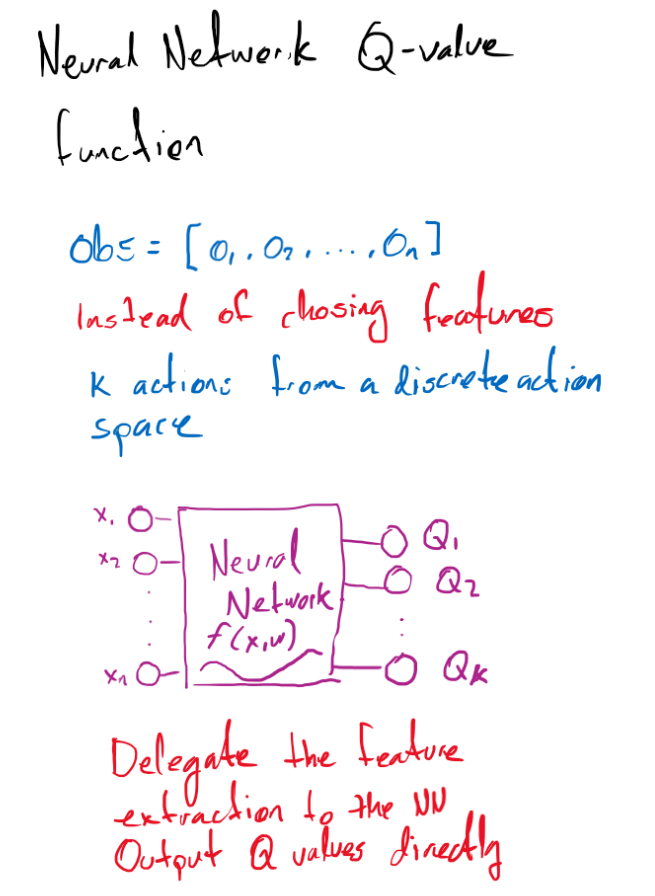

In [7]:
def processActions(actions):
    if isinstance(actions, np.ndarray):
        actions = torch.as_tensor(actions, dtype=torch.int64)
    elif isinstance(actions, int):
        actions = torch.tensor([actions])
    elif isinstance(actions, list):
        actions = torch.tensor(actions, dtype = torch.int64)
    else:
        raise TypeError("Type {} unsupported".format(type(actions)))
    return actions.unsqueeze(1)

def numpyFlat(d):
    d = torch.as_tensor(d, dtype=torch.float32)
    d = d.unsqueeze(0).flatten(1)
    return d

In [10]:
class NNQ(nn.Module):
    _h1_ = 24
    def __init__(self, env, epsilon:float = 0.1):
        if (epsilon <0) or (epsilon>1):
            raise ValueError("epsilon must be in [0,1]")

        from gym.spaces import Discrete
        if not isinstance(env.action_space, Discrete):
            # Just allow discrete actions
            raise ValueError("Env's action space not valid")
        self.action_space = env.action_space

        super(NNQ, self).__init__()
        self.inputs = torch.as_tensor(env.observation_space.sample()).flatten().shape
        self.output = self.action_space.n
        self.activation = torch.relu
        self.fc1 = nn.Linear(self.inputs[0], self._h1_)
        self.fc2 = nn.Linear(self._h1_ , self.output)

        self.test = False
        self.epsilon = epsilon

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x
    
    def getAction(self, x):
        if (np.random.uniform() > self.epsilon) or (self.test):
            return self.getMaxAction(x)
        else:
            return self.action_space.sample()

    def getMaxAction(self, x):
        return self.forward(x).argmax(dim=1).item()


In [8]:
from sklearn.model_selection import train_test_split

class gymAgentNNQ(Agent):
    def __init__(self, env, env_test = None, **kwargs):
        self.policy = NNQ(env)
        self.env = env
        self.env_test = env_test
        self.optimizer = optim.SGD(self.policy.parameters(), 
                                   lr=kwargs.get("learning_rate", 1e-4))
        self.lossFn = nn.functional.mse_loss
        self.trainLoss = []
        self.testLoss = []
        self.updates = 0
        super().__init__()

    def processObs(self, obs):
        return torch.as_tensor(obs, dtype=torch.float32).flatten().unsqueeze(0)
    
    def update(self, states, actions, returns):
        states = torch.cat(states, dim = 0).requires_grad_(True)
        actions = processActions(actions)
        returns = torch.tensor(returns, dtype = torch.float32).unsqueeze(1)

        idTrain, idTest = train_test_split(np.arange(states.shape[0]),
                                           test_size = 0.2)
        
        def calculateLoss(ids):
            qvalues = self.policy.forward(states[ids])
            qvalues = torch.gather(qvalues, 1, actions[ids])
            return self.lossFn(qvalues, returns[ids])

        loss = calculateLoss(idTrain)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        with torch.no_grad():
            self.trainLoss.append(loss.item())
            self.testLoss.append(calculateLoss(idTest).item())
            self.updates += 1


In [11]:
agentMCQ = gymAgentNNQ(env, learning_rate = 1e-3)

Para este primer acercamiento se buscará ajustar la función en el método de Monte-Carlo como el ejercicio pasado.

In [12]:
def GLIE_MC_TORCH(agent:Agent, iters: int, episodes:int = 30,
            gamma:float = 0.99, freqTest: int = 10**2, epsLife: int = None):
    """
    GLIE MC given an epsilon greedy policy

    parameters
    -----------
    agent: The Agent object which contains the environment
        and the policy
    iters: integer > 0
        Total number of iterations to run the policy and to improve from
    episodes: integer > 0
        Number of episodes to sample from to evaluate the policy
    gamma: float
        Discount factor
    freqTest: integer > 0
        The frequency in which a test to evaluate the policy performance is done
    """

    assert (gamma >= 0) and (gamma <= 1), \
        "Gamma discount factor must be in the interval [0,1]"
    assert episodes > 0, \
        "episodes needs to be am integer greater or equal to 1 iteration."
    assert iters > 0, \
        "iters needs to be am integer greater or equal to 1 iteration."

    if epsLife is None:
        epsLife = iters
    
    env = agent.env
    policy = agent.policy
    prosObs = agent.processObs
    
    testMean, testStd = [], []
    for iter in range(iters):

        # Adjust policy's episilon
        policy.epsilon = max(0, 1 - ((iter + 1) / epsLife))

        # Do evaluation if it is time
        if iter % freqTest == 0:
            returns, _ = agent.test(n_test = 30)
            testMean += [np.mean(returns)]
            testStd += [np.std(returns)]

        for episode in range(episodes):
            # Sample a whole episode
            obs = env.reset()
            done, states, actions, rewards, returns = False, [], [], [], []
            while not done:
                state = prosObs(obs)
                with torch.no_grad():
                    action = policy.getAction(state)
                # Save the states and action seen
                states += [state]
                actions += [action]
                # Do the step on the environment
                obs, reward, done, info = env.step(action) #Modificacion ligera
                rewards += [reward]
                returns += [0.0]

            # After done, calculate the returns
            returns[-1] = rewards[-1]
            for i in range(len(rewards) - 2, -1, -1): # i goes from the top to bottom of the lists
                returns[i] = rewards[i] + gamma * returns[i + 1]
            
            # Update the value function
            #agent.update(allStates, allActions, allReturns)
            agent.update(states, actions, returns)

    graphResults(testMean, testStd, freqTest * episodes, "GLIE")

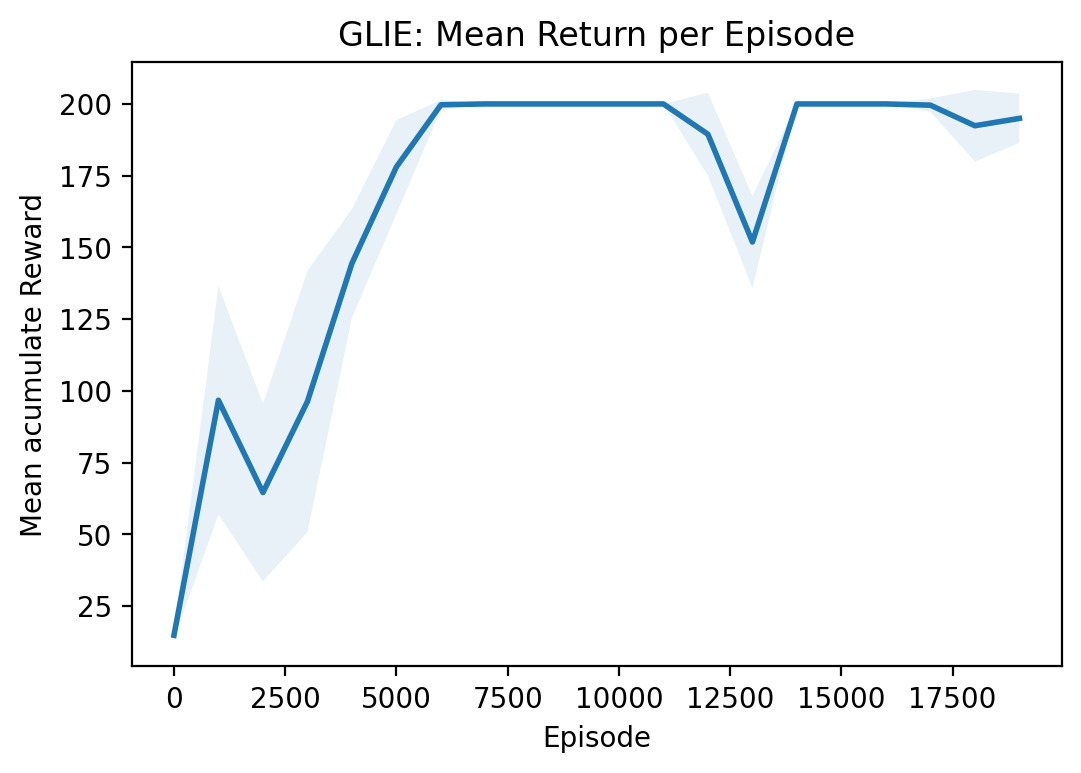

In [13]:
GLIE_MC_TORCH(agentMCQ, 200, episodes = 100, freqTest = 10, epsLife=300)

In [16]:
def graphErrorTrain(agent, dpi = 200):
    fig = plt.figure(dpi=dpi)
    plt.title("Train-Test Error")
    plt.xlabel("Update")
    plt.ylabel("log MSE loss")
    x = np.arange(agent.updates)
    plt.plot(x, np.log(agent.trainLoss), label = "Train error", alpha = 0.3)
    plt.plot(x, np.log(agent.testLoss), label= "Test error", alpha = 0.3)
    plt.legend()


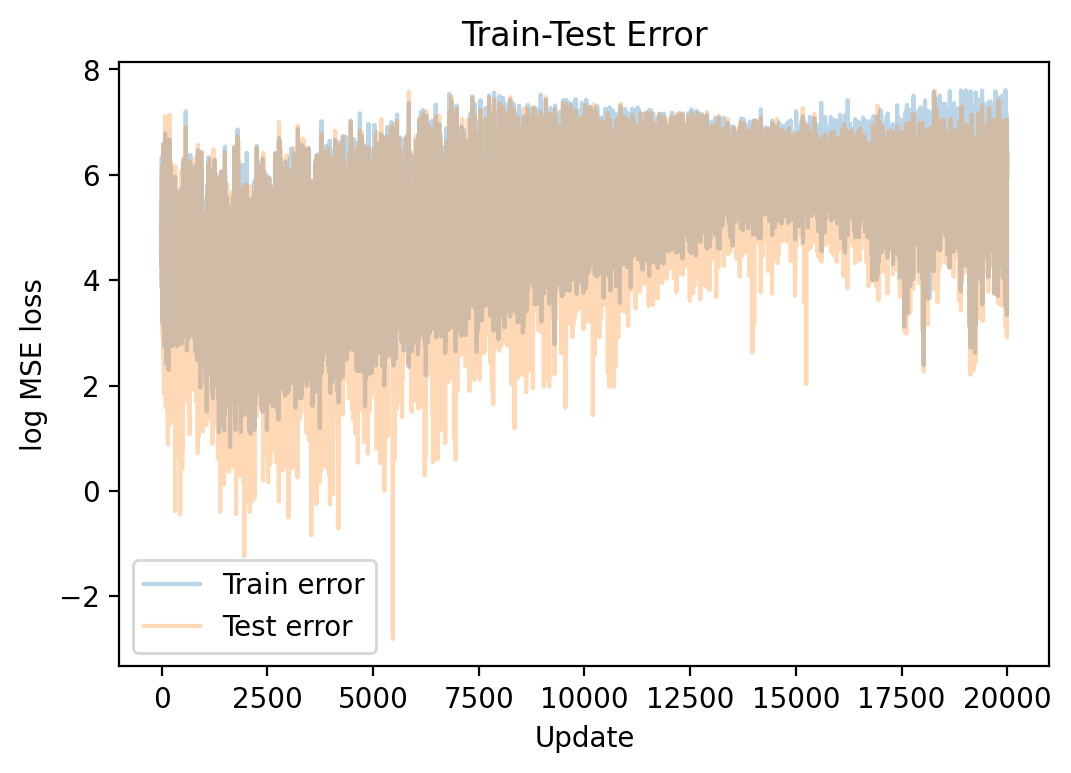

In [17]:
graphErrorTrain(agentMCQ)

Mean accumulate Reward 100.00, episodes 2


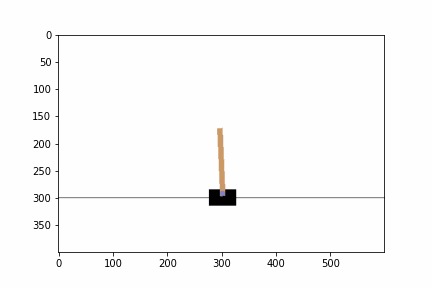

In [36]:
runAgent(agentMCQ, 200)

### ¿Qué hay acerca de Q-learning?

Se puede utilizar este tipo de entrenamiento de políticas parámetricas para entrenar utilizar Q-learning, se anteriormente se puede observar que es *más rapido*.
- ¿Que problemas generaría utilizar Q-learning?¿por que estos no están en esta implementación?
- ¿Que desventaja se tiene con esta implementación?
